# Livrable 2 : Classification

|Auteur|Centre|Modification|
|---|---|---|
|Emilien Pons|Toulouse|2021/01/15|
|Nicolas Hurtevent|Toulouse|2021/01/15|
|Pierre Mazurier|Toulouse|2021/01/15|
|Pacome Chu-Lejeune|Toulouse|2021/01/15|

![logoEI_1_6.jpg](https://arras.cesi.fr/wp-content/uploads/sites/9/2019/05/Cesi_Logo_INGENIEUR_RVB-HD-500x296.jpg)

## Introduction

L'entreprise TouNum, travaillant sur la numérisation de documents, nous demande de réaliser une solution d'image captioning. L'architecture de la solution est composée de plusieurs modules, comme décrit sur le schéma suivant.

[SCHEMA]

L'architecture de la solution d'image-captionning est composée de 4 modules : un module de chargement d'image, un module déterminant si l'image est une photo ou non, un troisième module de traitement basique d'image pour la rendre plus éxploitable et un dernier module de captionning.

L'entreprise souhaite automatiser la sélection de photos pour l'annotations. Nous allons donc, dans ce document, **détailler notre méthode permettant de filtrer si une image est une photo ou non**. Cette approche utilise des réseaux de neuronnes, nous allons comparer plusieurs modèles entrainés sur les mêmes données et les comparer.

Ce modèle sera utilisé par la suite sur la solution de captionning finale.

# PLAN

- Mise en place de TensorFlow
- Fonctions utilisées
    - Initialisation du notebook
    - Préparation des datasets
- Création des modèles
    - Petite intro pour parler des CNN et comme quoi modèle simple ne font pas l'affaire
    - Modèle Baseline
        - 1. Le modèle (avec schéma)
        - 2. Analyse des résultats
    - Modèle DNN
        - 1. Le modèle (avec schéma)
        - 2. Les paramètres
        - 3. La fonction de perte 
        - 4. Algorithmme d'optimisation pour l'entrainement
     - Analyse des résultats DNN
        - 1. Graphique analyse erreur entrainement
        - 2. Erreur de test
        - 3. Evolution de l'accuracy pour ces deux datasets
    - Modèle CNN 1
        - 1. Le modèle (avec schéma)
        - 2. Les paramètres
        - 3. La fonction de perte 
        - 4. Algorithmme d'optimisation pour l'entrainement
     - Analyse des résultats CNN 1
        - 1. Graphique analyse erreur entrainement
        - 2. Erreur de test
        - 3. Evolution de l'accuracy pour ces deux datasets
    - Compromis analyse de l'over/under feating
        - 1. Qu'est ce que c'est ?
        - 2. Interprétation de notre résultat
    - Comment améliorer nos résultats
    - Modèle CNN 2 (version améliorée)
        - 1. Le modèle (avec schéma)
        - 2. Les paramètres
        - 3. La fonction de perte 
        - 4. Algorithmme d'optimisation pour l'entrainement
     - Analyse des résultats CNN 2
        - 1. Graphique analyse erreur entrainement
        - 2. Erreur de test
        - 3. Evolution de l'accuracy pour ces deux datasets
     - Conclusion

## Mise en place de TensorFlow

Dans ce livrable, nous utilisons TensorFlow. C'est un outil d'apprentissage automatique développé par Google et l'un des outils les plus utilisés en IA dans le domaine du Machine Learning. Il nous offre une bibliothèque riche qui nous permettra de créer éfficacement des réseaux de neuronnes de toute architecture. C'est également l'outil que nous avons pu prendre en main lors de nos précèdents workshops.

![logo_TS](https://www.tensorflow.org/images/tf_logo_social.png)

**NB :** Si vous ne disposez pas encore de TensorFlow, l'instalation de la bibliothèque sous votre machine est la commande suivante. Vous pouvez aussi tenter de l'installer depuis la console Anaconda en suivant la [documentation](https://docs.anaconda.com/anaconda/user-guide/tasks/tensorflow/) officielle.

In [1]:
# pip install tensorflow

# Théorie

## Explication des Modèles
### Définition
Un modèle de machine learning est un algorithme entrainé à reconnaitre certains types de patterns. Un modèle est composé de différentes couches, compilé puis entrainé avec des données de teste. La phase d’entrainement pouvant être très longue, il est possible de sauvegarder le modèle et le réutiliser sans avoir à le réentraîner.

Sous TensorFlow, il est possible de créer un modèle de 2 manières : la méthode séquentielle et fonctionnelle.

#### Modèle séquentiel
Le modèle séquentiel est la manière la plus répandue pour créer des modèles. Le modèle est créé soit en passant une liste de couches à la fonction ```sequential()```.
```
const model = tf.sequential({
 layers: [
   tf.layers.dense({inputShape: [784], units: 32, activation: 'relu'}),
   tf.layers.dense({units: 10, activation: 'softmax'}),
 ]
});
```

Soit en utilisant la méthode ```add()```.
```
const model = tf.sequential();
model.add(tf.layers.dense({inputShape: [784], units: 32, activation: 'relu'}));
model.add(tf.layers.dense({units: 10, activation: 'softmax'}));
```

#### Modèle Fonctionnel
Il est possible de créer un modèle en utilisant la fonction ```tf.model``` de TensorFlow. Chaque couche est créée individuellement et connecté à l’aide de la fonction ```apply()```.
```
const input = tf.input({shape: [784]});
const dense1 = tf.layers.dense({units: 32, activation: 'relu'}).apply(input);
const dense2 = tf.layers.dense({units: 10, activation: 'softmax'}).apply(dense1);
const model = tf.model({inputs: input, outputs: dense2});
```
Cette méthode permet plus de customisation dans la création du modèle.

### Couches d’un modèle
Un modèle peut être composé de nombreuses couches différentes. Nous allons expliquer les plus fréquentes dans cette partie.

#### Dense
La couche ```Dense``` est une couche classique pour créer un réseau de neurone densément connecté, c’est-à-dire que chaque perceptron d’une couche est connecté à tous les autres perceptrons de la couche suivante.

![Densely connected Neural Network](https://stackabuse.s3.amazonaws.com/media/deep-learning-in-keras-building-a-deep-learning-model-1.png)

Avec cette fonction on peut régler des paramètres comme le nombre de perceptrons dans la couche (```units```) ou la fonction d’activation (```activation```), etc.

#### Conv2D
La couche ```Conv2D``` permet d’obtenir un couche de convolution spatiale sur une image. C’est-à-dire que chaque perceptron sera lié à un masque de convolution à un endroit donné de l’image. Nous utilisons ce type de couche pour créer des réseaux de neurones convolutifs.

![Convolution layers](https://miro.medium.com/max/3744/1*CnNorCR4Zdq7pVchdsRGyw.png)

Il est possible de régler des paramètres comme les dimensions du masque de convolution utilisé (```kernel_size```), le type de filtre utilisé (```filters```), le padding (```padding```), etc.

#### MaxPooling2D
Il est possible de créer une couche de max pooling avec ```MaxPooling2D```. Une telle couche permet de calculer la plus grande valeur pour chaque features d’une image. 

C’est en général utilisé à la suite d’une couche de convolution.

#### Flatten
La couche ```Flatten``` permet de fusionner plusieurs images en une seule dimension.

Cette couche est souvent utilisé à la suite de plusieurs couches de convolutions pour obtenir un résultat final exploitable par (par exemple) un réseau de neurones récurant.

### Compilation
Une fois instancié, sous TensorFlow, le modèle est configuré à l’aide de la méthode ```compile()```. Cela permet de définir des paramètres tels que l’optimiseur, la fonction de coût et les métriques utilisés pour évaluer le modèle.

#### Optimiseur
Le paramètre ```optimizer``` de la méthode ```compile()``` de TensorFlow permet de définir quel fonction sera utilisé lors de la modification des poids dans la phase de test du modèle. Il en existe de [nombreux]( https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), les plus répandus étant ```RMSprop```, ```SGD``` et ```Adam```.

Le plus souvent, l’optimiseur ```Adam``` est utilisé, c’est en quelque sorte un algorithme de descente de gradient stochastique avec un ```learning rate``` variable.

Plus d’informations techniques peuvent être trouvées [ici]( https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c).

#### Fonction de coût
Le paramètre ```loss``` de la méthode ```compile()``` de TensorFlow permet de définir la fonction utilisée pour calculer les coût et mesurer la performance du modèle.

Il en existe de [nombreux]( https://www.tensorflow.org/api_docs/python/tf/keras/losses), l’un des plus fréquent est le ```SparseCategoricalCrossEntropy```.

#### Métrique
Le paramètre ```metric``` de le méthode ```compile()``` de TensorFlow permet de lister les métriques que l’on souhaite évaluer par le modèle pendant les phases d’entrainement et de test.

Il en existe de [nombreux](https://www.tensorflow.org/api_docs/python/tf/keras/metrics), et dérivent, pour une bonne partie, de la matrice de confusion qui ressence les résultats des prédictions du modèle sur un jeu de données en fonction des résultats véritables, comme illustré sur le schéma suivant.

![Matrice de confusion]( https://www.researchgate.net/profile/Hazem_Wannous/publication/281162229/figure/fig59/AS:660706189918256@1534536039792/Matrice-de-confusion.png)

A partir de cette matrice, il est possible de calculer de nombreuses métriques comme, par exemple l’```accuracy```, le ```recall```, etc. Une liste complète des métriques avec les formules correspondantes se trouve [ici]( https://en.wikipedia.org/wiki/Confusion_matrix).

En général, l’```accuracy``` est une métrique utilisée, celle-ci représente le nombre de bonne prédictions (positives et négatives) sur le nombre totale de prédictions.

### Entrainement
Pendant la phase d’entrainement, l’algorithme va modifier des paramètres, comme les poids associés aux liaisons entre les perceptrons des différentes couches. Lors de cette phase, l'algorithme va tourner sur différentes images, en des boucles que l'on appelle "epoques" (ou ```epochs```).

Lors de l’entrainement, l’optimisation des paramètres se fera selon la fonction spécifiée lors de la compilation du modèle, voir partie [Compilation].

# Pratique

# Import du dataset

In [54]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from PIL import Image
import os, os.path
import pathlib

In [55]:
img_height = 256
img_width = 256
batch_size = 32

image_h = img_height
image_w = img_width
batch_s = batch_size

In [56]:
data_dir = "dataset/subsample"
data_dir = pathlib.Path(data_dir)

#load images and split train and test sets
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=  0.2,
  subset = 'training',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=  0.2,
  subset = 'validation',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


On vérifie qu'on a bien les bonnes classes

In [57]:
class_names =  train_set.class_names #a compl
print(class_names)
print(train_set)

['notphoto', 'photo']
<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [58]:
def plot_history(history) :
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

On affiche quelques exemples de ce que contient notre dataset

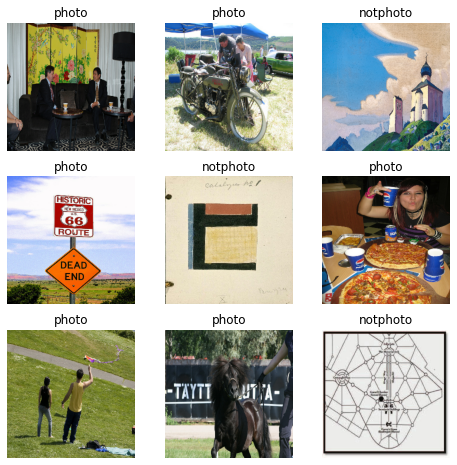

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8")) #a compl
        plt.title(class_names[labels[i]])
        plt.axis("off")

On a confirmé le contenu du dataset chargé. On peut donc maintenant le préparer pour nos modèles
On mélange donc le jeu d'entrainement pour éviter que le modèle n'apprenne à reconnaitre un ordre particulier si les données étaient triées. Il pourait par exemple remarquer sur des données triées qu'on a toujours "5 photos puis 5 tableau puis 5 photos ..." et le mélange permet d'éviter ce biais.
On ajoute également des options de caching et de prefteching pour préparer le batch suivant en avance et garder les images en mémoire. Ces options devraient grandement réduire le temps nécessaire à l'entrainement.

In [60]:
# #shuffle the train set
# #add caching and prefeching optimisations
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(100000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Modèles

## 1. Modèle naïf

    Nous allons établir un modèle de base qui soit le plus simple possible. Celui-ci va donc simplement toujours retourner la classe l pluq fréquente. Notre dataset contient 10000 images dans chaque classe. On devrait donc obtenir une accuracy avoisinant les 50%.

On utilise un modèle de scikit-learn qui apprend à retourner la valeur la plus courrante dans le jeu de donnée

In [66]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")

Plutôt que de relire les images, on réupère les valeurs présentes dans les batch du dataset créé précédement.
On se limite également à un échantillon de 100 batches de 32 images, soit 3200 images. Cet échantillonage nous offre un gain significatif de temps et le résultat final ne devrait pas beaucoup différer sur ce modèle par rapport à un entrainement fait sur les 20000 images.

In [67]:
#extract X_test and y_test back from the test set
X_test = []
y_test = []
# Only use 100 batches, or 32000 images.
# It's enough to get a good approximation of the proportion were we to use all 20000 images but saves execution time
for images, labels in test_set.take(10): 
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

In [68]:
#extract X_train and y_train back from the train set
X_train = []
y_train = []
# Only use 100 batches, or 32000 images.
# It's enough to get a good approximation of the proportion were we to use all 20000 images but saves execution time
for images, labels in train_set.take(10):
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

On entraine le modèle. Il va simplement trouver la classe la plus fréquente et la retournera toujours par la suite.

In [ ]:
dummy_clf.fit(X_train, y_train)

Enfin on calcule l'accuracy de ce modèle.

In [76]:
dummy_acc = dummy_clf.score(X_test, y_test)
print(dummy_acc)

0.496875


**Conclusion :** 

On obtient une accuracy de 50% en moyenne. On sait comme dit auparavant que notre dataset comprend 10000 images de photos et 10000 image qui ne sont pas des photos. Une légère différence pouvant aller jusqu'à plus ou moins 2% est mesurée d'un test à l'autre et est explicable par le fait qu'on entraine le modèle sur un échantillon de 3200 images parmi les 20000.


Puisque de 50% est l'accuracy obtenue par un modèle aussi simple, il faudra donc que nos modèles suivants dépassent ce seuil pour justifier leur utilisation.

## 2. Utilisation d'un DNN

Dans ce second modèle, nous utilisons un [DNN](https://en.wikipedia.org/wiki/Deep_learning#Deep_neural_networks) (deep neural network). C'est une catégories d'[ANN](https://en.wikipedia.org/wiki/Artificial_neural_network) composé de plusieurs couches. Dans notre cas, notre DNN est simple et n'est composé que de deux couches denses de 128 neurones chacunes et un dropout à 20% sur chaque couche pour éviter le surapprentissage. Plus de détails sur ces notions sera fournis dans la suite de ce document.

![DNN](images/DNN.png)

On créé notre modèle

In [72]:
model_dense = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [73]:
model_dense.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               25165952  
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                

On le compile

In [ ]:
model_dense.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Et on l'entraine sur 10 époques en enregistrant ses performances à chaque époque

In [74]:
epochs=10
history =  model_dense.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
500/500 [==============================] - 139s 279ms/step - loss: 1.4962 - accuracy: 0.5024 - val_loss: 0.6934 - val_accuracy: 0.4890
Epoch 2/10
500/500 [==============================] - 102s 204ms/step - loss: 0.6930 - accuracy: 0.5033 - val_loss: 0.6929 - val_accuracy: 0.4893
Epoch 3/10
500/500 [==============================] - 102s 204ms/step - loss: 0.6927 - accuracy: 0.5029 - val_loss: 0.6924 - val_accuracy: 0.4893
Epoch 4/10
500/500 [==============================] - 82s 165ms/step - loss: 0.7005 - accuracy: 0.5029 - val_loss: 0.6925 - val_accuracy: 0.4893
Epoch 5/10
500/500 [==============================] - 98s 195ms/step - loss: 0.6923 - accuracy: 0.5027 - val_loss: 0.6915 - val_accuracy: 0.4890
Epoch 6/10
500/500 [==============================] - 81s 162ms/step - loss: 0.7051 - accuracy: 0.5028 - val_loss: 0.6910 - val_accuracy: 0.4893
Epoch 7/10
500/500 [==============================] - 84s 168ms/step - loss: 0.6920 - accuracy: 0.5029 - val_loss: 0.6921 - val

On affiche sous forme de graphe la valeur de la fonction de coût et l'accuracy à chaque époque

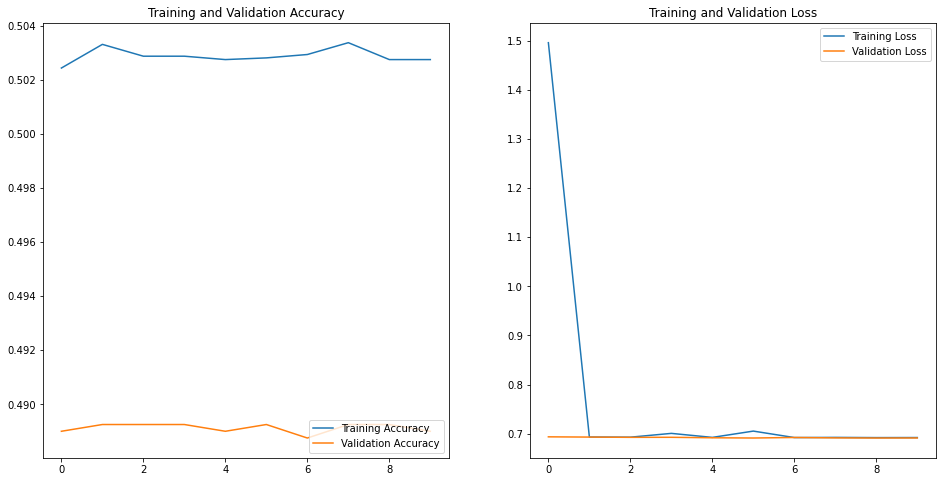

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_dnn_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

//Conclu : 
Bien que le DNN soit un réseau de neuronne très simple, il ne permet pas encore d'obtenir des résultats satisfaisants. Il va falloir utiliser des modèles plus spécialisés pour la classification dans le traitement d'image tels que des CNN.

3. CNN juste avec convo+pooling

Dans ce troisième modèle, nous introduisons le principe des [CNN](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif). C'est un empilement de couches de perceptrons qui vont nous aider à prétraiter et déterminer des caractéristiques à l'aide de ses deux principes : La convolution et le pooling.
- La convolution vient appliquer dynamiquement des filtres qui permettent de détecter les bords de l'image de manière optimale et de pouvoir reconnaître des formes.
- Le pooling vient à à cibler et détecter ces zones pour détecter des caractéristiques. On perd donc en résolution mais on se concentre sur une partie de l'image pour trouver son caractère. 

In [77]:
model_cnn_nopad = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [78]:
model_cnn_nopad.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [79]:
model_cnn_pad_128 = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [80]:
model_cnn_pad_128.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [82]:
model_cnn_pad_64 = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [83]:
model_cnn_pad_64.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
model_cnn_nopad.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 64)      

In [85]:
# test du nodpad

In [ ]:
epochs=10
history =  model_cnn_nopad.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
500/500 [==============================] - 463s 926ms/step - loss: 0.4426 - accuracy: 0.7625 - val_loss: 0.3853 - val_accuracy: 0.8048
Epoch 2/10
500/500 [==============================] - 464s 928ms/step - loss: 0.3321 - accuracy: 0.8481 - val_loss: 0.3429 - val_accuracy: 0.8547
Epoch 3/10
500/500 [==============================] - 499s 997ms/step - loss: 0.2752 - accuracy: 0.8735 - val_loss: 0.3563 - val_accuracy: 0.8220
Epoch 4/10
500/500 [==============================] - 470s 939ms/step - loss: 0.2098 - accuracy: 0.9071 - val_loss: 0.3229 - val_accuracy: 0.8692
Epoch 5/10
 83/500 [===>..........................] - ETA: 5:49 - loss: 0.1546 - accuracy: 0.9364

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_nopad_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# test du pad 128

In [ ]:
epochs=10
history =  model_cnn_pad_128.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_pad_128_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# test du pad 64

In [ ]:
epochs=10
history =  model_cnn_pad_64.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_pad_64_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

//Conclu :
Bien que le CNN fournisse une très bonnes accuracy, la différence entre le jeux d'entrainement et le jeux de test sur le graphique nous montre qu'il y a énormément d'overfitting.
L'overfitting est très courrant en Machine Learning, et fort heureusement, il existe de nombreuses méthodes pour l'atténuer qui sont appellées des techniques de régularisation

#### Régularisation

En machine learning, la régularisation est une façon de prévenir l'overfitting.
La régularisation reduit l'overfitting en ajoutant une pénalité à la fontion de coût.
En ajoutant cette pénalité, le modèle est entraîné de telle sorte qu'il n'apprend pas un ensemble de poids de caractéristiques interdépendantes. 
De telles techniques de régularisation sont "L1 regularization" (Lasso Regression) et "L2 regularization" (Rigde Regression).

La Ridge Regression ajoute la "squared magnitude" (magnitude au carré) du coefficient comme terme de pénalité à la fonction de coût.

![image.png](attachment:image.png)

Ici, si le lambda est égal à zéro, on peut imaginer que l'on récupère l'OLS (ordinary least squares). En revanche, si le lambda est très grand, il ajoutera trop de poids et entraînera un under-fitting : la manière dont le lambda est choisi est importante. Cette technique fonctionne très bien pour éviter les problèmes d'over-fitting.


Lasso Regression (Least Absolute Shrinkage and Seletion Operator) ajoute "absolute value of magnitude" (valeur absolue de la magnitude) du coefficient comme terme de pénalité à la fonction de coût.

![image-2.png](attachment:image-2.png)

La principale différence entre ces tehniques est que le lasso réduit le coefficient de la caractérisques les moins importantes à zéro, supprimant ainsi certaines features en totalité. Cela fonctionne donc bien pour la features selection dans le cas où nous avons un grand nombre de features.

Les méthodes traditionnelles telles que la cross-validation, stepwise regression pour gérer l'over-fitting et la feature selection fonctionnent bien avec de petits ensemble de feature, mais L1 et L2 regression sont une excellente alternative lorsque nous avons affaire à une grand nombre de features.

## Modèle 2 : ajout du dropout

Le premier paramètre que nous utilisons pour améliorer notre CNN est le Dropout.

#### Dropout

La méthode du dropout consiste à ignorer des unités (neurone) durant la phase d'entraînement de façon aléatoire, elles ne sont ni considéré durant le forward-pass ou backward-pass. Ignorer un neurone veut dire l'enlever temporairement du réseau, avec toutes ses connections entrantes et sortantes.

Le dropout a changé le concept d'apprentissage de tous les poids ensemble pour l'apprentissage d'une fraction des poids dans le réseau à chaque itération.

![image-3.png](attachment:image-3.png)

On utilise le dropout pour éviter l'over-fitting. Un réseau densemment connecté occupe la majeur partie de ses paramètres et les neurones développent une co-dépendance entre eux pendant l'entraînement, ce qui limite la puissance individuelle de chaque neurone et conduit à un over-fitting des données d'entraînement.  
Plus précisément, la co-dépendance ou co-adaptation est une issue majeur des réseaux de neurones larges. Dans un tel network, si tout les poids sont entraîner ensemble, il est commun que certaines connections developpent des capacités de prédictions supérieur aux autres.  
Dans un tel scénario, comme le réseau est entraîné itérativement, ces connections plus puissantes apprennent plus pendant que les plus faibles sont ignorées. Sur plusieurs itérations, une fraction des connexions des nodes sont entraînées et le reste arrête de participer.  
En pratique, le dropout est implémenté par couche sur un réseau neuronal.  
Il peut être utilisé sur la plupart des couches, comme les couches denses, convolutionel ainsi que récurrentes comme Long Short-Term Memory.  
##### En utilisant Keras :  
La couche de dropout règle aléatoirement les unités d'entrée sur 0 avec une fréquence de <code translate="no" dir="ltr">rate</code> à chaque étape pendant la durée d'entraînement. Les entrés qui ne sont pas réglées sur 0 sont augmentées de 1/(1 - <code translate="no" dir="ltr">rate</code>) de sorte que la somme de toutes les entrées reste inchangée.

In [ ]:
model_cnn_dropout = models.Sequential([
  layers.Conv2D(32, 3, padding='valid', activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [ ]:
model_cnn_dropout.summary()

In [ ]:
model_cnn_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=20
history =  model_cnn_dropout.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_dropout_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

//Conclu : 
Le dropout a retardé l'overfitting et nous a permis d'atteindre une accuracy plus élevée mais on peut encore faire mieux

## Modèle 3 : dropout + data augmentation

#### Data augmentation

Une façon simple d'améliorer les performances de notre model est d'augmenter la quantité de données pour l'entraînement, cela simplement en récoltant plus de données.  
Dans le cas où c'est impossible, on peut augmenter la quantité de données en ajoutant des copies légèrements modifiées des données existantes ou en créant de nouvelle données synthétiques à partir de données existantes.
Lorsqu'on utilise des images, pour les modifier on peut les retourner (flip, rotation, etc), changer les couleurs, injecter du bruit, effacer des parties de l'images, etc.

In [ ]:
data_augmentation = models.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(image_h, image_w, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(height_factor= 0.1)
  ]
)

In [ ]:
model_cnn_dropout_augmentation = models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
  data_augmentation,
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [ ]:
model_cnn_dropout_augmentation.compile(optimizer =  'adam', #A COMPLETER
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #A COMPLETER
              # loss = tf.keras.losses.SparseCategoricalCrossentropy(), #A COMPLETER
              metrics=['accuracy'])

In [ ]:
model_cnn_dropout_augmentation.summary()

In [ ]:
epochs=20
history =  model_cnn_dropout_augmentation.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_dropout_augmentation_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

//Conclusion : 
Les résultats sont mantenant bien plus cohérents et satisfaisons. Notre modèle est entrainé correctement avec une très bonne accuracy. 

6. Divers sur l'overfeating

Il existe d'autres méthodes que le Dropout et le Data Augmentation pour rendre nos résultats dans l'overfeating. //Insérer travail de pacome ici

#### Regularization

En machine learning, la regularisation est une façon de prévenir l'over-fitting.
Regularisation reduit l'over-fitting en ajoutant une pénalité à la fontion de coût.
En ajoutant cette pénalité, le model est entraîné de telle sorte qu'il n'apprend pas un ensemble de poids de caractéristiques interdépendantes. 
Deux telles techniques de régularisation sont L1 regularization (Lasso Regression) et L2 regularization (Rigde Regression).
Ridge Regression ajoute "squared magnitude" (magnitude au carré) du coefficient comme terme de pénalité à la fonction de coût.

![image.png](attachment:image.png)

Ici, si le lambda est égal à zéro, on peut imaginer que l'on récupère l'OLS (ordinary least squares). En revanche, si le lambda est très grand, il ajoutera trop de poids et entraînera un under-fitting : la manière dont le lambda est choisi est importante. Cette technique fonctionne très bien pour éviter les problèmes d'over-fitting.


Lasso Regression (Least Absolute Shrinkage and Seletion Operator) ajoute "absolute value of magnitude" (valeur absolue de la magnitude) du coefficient comme terme de pénalité à la fonction de coût.

![image-2.png](attachment:image-2.png)

La principale différence entre ces tehniques est que le lasso réduit le coefficient de la caractérisques les moins importantes à zéro, supprimant ainsi certaines features en totalité. Cela fonctionne donc bien pour la features selection dans le cas où nous avons un grand nombre de features.

Les méthodes traditionnelles telles que la cross-validation, stepwise regression pour gérer l'over-fitting et la feature selection fonctionnent bien avec de petits ensemble de feature, mais L1 et L2 regression sont une excellente alternative lorsque nous avons affaire à une grand nombre de features.

In [ ]:
# #on peut faire un tableau comparatif des modèles
# from sklearn.dummy import DummyClassifier
# dummy_clf = DummyClassifier(strategy="most_frequent")

In [ ]:
# X_train = []
# y_train = []
# for images, labels in train_set:  # only take first element of dataset
#     X_train = np.append(X_train, images.numpy())
#     print(X_train)
#     y_train = np.append(y_train, labels.numpy())
#     print(y_train)
# print(y_train)
# print(X_train)

In [ ]:
# X_train = ()
# y_train = ()
# for images, labels in train_set.take(-1):  # only take first element of dataset
#     X_train = images.numpy()
#     y_train = labels.numpy()
# print(X_train)
# print(y_train)

In [ ]:
# X_test = ()
# y_test = ()
# for images, labels in test_set.take(-1):  # only take first element of dataset
#     X_test = images.numpy()
#     y_test = labels.numpy()
# print(X_test)
# print(y_test)

In [ ]:
# dummy_clf.fit(X_train, y_train)
# # dummy_acc = dummy_clf.score(X_test, y_test)

In [ ]:
# dummy_acc = dummy_clf.score(X_test, y_test)
# print(dummy_acc)

In [ ]:
print(max(model_cnn_pad_64_acc))

In [ ]:
from tabulate import tabulate
print(tabulate([['Naive model', dummy_acc], 
                ['DNN 128', max(model_dnn_acc)],
                ['CNN no pad 64', max(model_cnn_nopad_acc)],
                ['CNN pad 64', max(model_cnn_pad_64_acc)],
                ['CNN pad 128', max(model_cnn_pad_128_acc)],
                ['CNN pad 64 + dropout', max(model_cnn_dropout_acc)],
                ['CNN pad 64 + dropout + data augmentation', max(model_cnn_dropout_augmentation_acc)],
               ], headers=['Model', 'Accuracy']))

In [ ]:
#pas hésiter a ref les papier qui montrenet que tel modèle marche le mieux (et coup de bol c'est le notre)

In [ ]:
#grille d'éval : 1 implé (bon params et explication adaptée),2 description de l'archi et visualisation des résultats : dessin de l'archi,graph de compa pour chaque modèle et commentaire. on a sans rien, aved dropout et avec data augment. 3 conclue : points forts et faibles et piste d'amélio (style transfer learning)